In [1]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen

import random
import numpy as np
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict
import matplotlib.pyplot as plt


import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS
from textblob import TextBlob
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter


# Load Data



In [2]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/sample/sample_meta_Home_and_Kitchen.json
!wget http://deepyeti.ucsd.edu/jianmo/amazon/sample/sample_Home_and_Kitchen_5.json

--2021-12-19 21:53:24--  http://deepyeti.ucsd.edu/jianmo/amazon/sample/sample_meta_Home_and_Kitchen.json
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9741929 (9.3M) [application/json]
Saving to: ‘sample_meta_Home_and_Kitchen.json’

sample_meta_Home_an 100%[===================>]   9.29M  19.3MB/s    in 0.5s    

2021-12-19 21:53:25 (19.3 MB/s) - ‘sample_meta_Home_and_Kitchen.json’ saved [9741929/9741929]

--2021-12-19 21:53:25--  http://deepyeti.ucsd.edu/jianmo/amazon/sample/sample_Home_and_Kitchen_5.json
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29033132 (28M) [application/json]
Saving to: ‘sample_Home_and_Kitchen_5.json’

sample_Home_and_Kit 100%[===================>]  

In [3]:
# load all metadata
data = []
with open('sample_meta_Home_and_Kitchen.json', 'r') as f:
    for l in tqdm(f):
        data.append(json.loads(l))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


0it [00:00, ?it/s]

In [4]:
# load all metadata
data1 = []
with open('sample_Home_and_Kitchen_5.json', 'r') as f:
    for l in tqdm(f):
        data1.append(json.loads(l))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


0it [00:00, ?it/s]

# Transform and clean data

In [5]:
# convert list into pandas dataframe

df = pd.DataFrame.from_dict(data)

print(len(df))

3025


In [6]:
# convert list into pandas dataframe

df1 = pd.DataFrame.from_dict(data1)

print(len(df1))

41047


In [7]:
#Merge the metadata and reviews datasets
dataset=pd.merge(df1,df,on=['asin'],how='left')

In [8]:
dataset.shape

(43233, 27)

In [9]:
dataset=dataset.drop_duplicates(subset=['asin', 'reviewerName','unixReviewTime'])

In [10]:
dataset.shape

(37905, 27)

In [11]:
dataset.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,vote,image_x,category,description,title,brand,feature,rank,also_view,main_cat,price,image_y,similar_item,also_buy,date,tech1,details
0,4.0,True,"08 3, 2014",A2LVMEG7IP5F90,B00002N62Y,jeff,good product and price,Four Stars,1407024000,NaN,NaN,NaN,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,"[Limit 1 per order, Returns will not be honore...",">#1,098,930 in Home & Kitchen (See Top 100 in ...","[B004B54FM4, B014N37IBI, B00VH79FH4, B008MKNG6...",Amazon Home,$4.36,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,True,"04 26, 2013",A3H3KQLUND2L3K,B00002N62Y,Nathan,These belts are $2+ retail and some retailers/...,Great price - OEM belts!,1366934400,NaN,NaN,NaN,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,"[Limit 1 per order, Returns will not be honore...",">#1,098,930 in Home & Kitchen (See Top 100 in ...","[B004B54FM4, B014N37IBI, B00VH79FH4, B008MKNG6...",Amazon Home,$4.36,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,True,"03 8, 2013",A3T5EP972YUQV0,B00002N62Y,musicman330,These came in a 2 pk and are perfect fit for m...,2fer wow,1362700800,NaN,NaN,NaN,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,"[Limit 1 per order, Returns will not be honore...",">#1,098,930 in Home & Kitchen (See Top 100 in ...","[B004B54FM4, B014N37IBI, B00VH79FH4, B008MKNG6...",Amazon Home,$4.36,NaN,NaN,NaN,NaN,NaN,NaN
6,5.0,True,"09 17, 2012",AIZY1SHWZ6CIQ,B00002N62Y,JR,"So my super fancy vacuum cleaner, the one with...",WOWEE!!!,1347840000,NaN,NaN,NaN,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,"[Limit 1 per order, Returns will not be honore...",">#1,098,930 in Home & Kitchen (See Top 100 in ...","[B004B54FM4, B014N37IBI, B00VH79FH4, B008MKNG6...",Amazon Home,$4.36,NaN,NaN,NaN,NaN,NaN,NaN
8,4.0,True,"11 3, 2017",A28UAJTMBWQYRG,B00002N62Y,kevin,Right one for my eureka.,Four Stars,1509667200,NaN,NaN,NaN,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,"[Limit 1 per order, Returns will not be honore...",">#1,098,930 in Home & Kitchen (See Top 100 in ...","[B004B54FM4, B014N37IBI, B00VH79FH4, B008MKNG6...",Amazon Home,$4.36,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#Checking for null values
dataset.isnull().sum()

overall               0
verified              0
reviewTime            0
reviewerID            0
asin                  0
reviewerName          4
reviewText            5
summary               5
unixReviewTime        0
style             21749
vote              30662
image_x           37508
category              0
description        3815
title                 0
brand               161
feature            1922
rank                 56
also_view         28749
main_cat              0
price             12054
image_y            5028
similar_item       9572
also_buy          20819
date              35298
tech1             37250
details           37679
dtype: int64

In [13]:
dataset=dataset.drop(columns=['vote','style','image_x','price','also_buy','tech1','details','also_view','date','similar_item','date','image_y','rank','feature'])

In [14]:
#Checking for null values
dataset.isnull().sum()

overall              0
verified             0
reviewTime           0
reviewerID           0
asin                 0
reviewerName         4
reviewText           5
summary              5
unixReviewTime       0
category             0
description       3815
title                0
brand              161
main_cat             0
dtype: int64

In [15]:
#fix missing data of the reviewtext column
dataset['reviewText']=dataset['reviewText'].fillna('Missing')

In [16]:
#fix missing data of the reviewtext column
dataset['summary']=dataset['summary'].fillna('Missing')

In [17]:
#fix missing data of the reviewtext column
dataset['description']=dataset['description'].fillna('Missing')

In [18]:
dataset.isnull().sum()

overall             0
verified            0
reviewTime          0
reviewerID          0
asin                0
reviewerName        4
reviewText          0
summary             0
unixReviewTime      0
category            0
description         0
title               0
brand             161
main_cat            0
dtype: int64

In [19]:
#remove HTML tags from title
dataset1=dataset.fillna('')
dataset2 = dataset1[dataset1.title.str.contains('getTime')] # unformatted rows
reviews = dataset1[~dataset1.title.str.contains('getTime')] # filter those unformatted rows
print(len(dataset2))
print(len(reviews))

568
37337


In [20]:
reviews.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,category,description,title,brand,main_cat
0,4.0,True,"08 3, 2014",A2LVMEG7IP5F90,B00002N62Y,jeff,good product and price,Four Stars,1407024000,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home
2,5.0,True,"04 26, 2013",A3H3KQLUND2L3K,B00002N62Y,Nathan,These belts are $2+ retail and some retailers/...,Great price - OEM belts!,1366934400,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home
4,5.0,True,"03 8, 2013",A3T5EP972YUQV0,B00002N62Y,musicman330,These came in a 2 pk and are perfect fit for m...,2fer wow,1362700800,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home
6,5.0,True,"09 17, 2012",AIZY1SHWZ6CIQ,B00002N62Y,JR,"So my super fancy vacuum cleaner, the one with...",WOWEE!!!,1347840000,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home
8,4.0,True,"11 3, 2017",A28UAJTMBWQYRG,B00002N62Y,kevin,Right one for my eureka.,Four Stars,1509667200,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home


In [21]:
#combine summary column and reviewtxt columns
reviews['review']=reviews['reviewText']+reviews['summary']
reviews=reviews.drop(['reviewText', 'summary'], axis=1)
reviews.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,overall,verified,reviewTime,reviewerID,asin,reviewerName,unixReviewTime,category,description,title,brand,main_cat,review
0,4.0,True,"08 3, 2014",A2LVMEG7IP5F90,B00002N62Y,jeff,1407024000,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,good product and priceFour Stars
2,5.0,True,"04 26, 2013",A3H3KQLUND2L3K,B00002N62Y,Nathan,1366934400,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,These belts are $2+ retail and some retailers/...
4,5.0,True,"03 8, 2013",A3T5EP972YUQV0,B00002N62Y,musicman330,1362700800,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,These came in a 2 pk and are perfect fit for m...
6,5.0,True,"09 17, 2012",AIZY1SHWZ6CIQ,B00002N62Y,JR,1347840000,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,"So my super fancy vacuum cleaner, the one with..."
8,4.0,True,"11 3, 2017",A28UAJTMBWQYRG,B00002N62Y,kevin,1509667200,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,Right one for my eureka.Four Stars


# Text preprocessing

In [22]:
stop_words = set(STOPWORDS)
print(stopwords)

<WordListCorpusReader in '.../corpora/stopwords' (not loaded yet)>


In [23]:
#update the list of the stopwords to match sentiment analysis
#keep words like didn't no don't that they show sentiment
stopwords= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [24]:
def Text_cleaning(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    text = [x for x in text if x not in stopwords]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # remove words with  one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [25]:
reviews['review']=reviews['review'].apply(lambda x:Text_cleaning(x))
reviews.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,unixReviewTime,category,description,title,brand,main_cat,review
0,4.0,True,"08 3, 2014",A2LVMEG7IP5F90,B00002N62Y,jeff,1407024000,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,good product pricefour stars
2,5.0,True,"04 26, 2013",A3H3KQLUND2L3K,B00002N62Y,Nathan,1366934400,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,belts retail retailers/sellers use generic/non...
4,5.0,True,"03 8, 2013",A3T5EP972YUQV0,B00002N62Y,musicman330,1362700800,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,came pk perfect fit good old vac seem strong d...
6,5.0,True,"09 17, 2012",AIZY1SHWZ6CIQ,B00002N62Y,JR,1347840000,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,super fancy vacuum cleaner one cold fusion rea...
8,4.0,True,"11 3, 2017",A28UAJTMBWQYRG,B00002N62Y,kevin,1509667200,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,right one eureka.four stars


# Feature engineering

In [26]:
#create 3 label categories 
def create_label(r):
    
    if r['overall'] == 3.0:
        value = 'Neutral'
    elif r['overall'] == 1.0 or r['overall'] == 2.0:
        value = 'Negative'
    elif r['overall'] == 4.0 or r['overall'] == 5.0:
        value = 'Positive'
    else:
        value = -1
    return value

In [27]:
reviews['label'] = reviews.apply(create_label, axis=1)

In [28]:
reviews.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,unixReviewTime,category,description,title,brand,main_cat,review,label
0,4.0,True,"08 3, 2014",A2LVMEG7IP5F90,B00002N62Y,jeff,1407024000,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,good product pricefour stars,Positive
2,5.0,True,"04 26, 2013",A3H3KQLUND2L3K,B00002N62Y,Nathan,1366934400,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,belts retail retailers/sellers use generic/non...,Positive
4,5.0,True,"03 8, 2013",A3T5EP972YUQV0,B00002N62Y,musicman330,1362700800,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,came pk perfect fit good old vac seem strong d...,Positive
6,5.0,True,"09 17, 2012",AIZY1SHWZ6CIQ,B00002N62Y,JR,1347840000,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,super fancy vacuum cleaner one cold fusion rea...,Positive
8,4.0,True,"11 3, 2017",A28UAJTMBWQYRG,B00002N62Y,kevin,1509667200,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,right one eureka.four stars,Positive


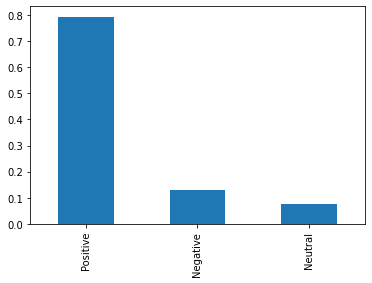

In [29]:
#allows plots to appear in the notebook
%matplotlib inline
reviews.label.value_counts(normalize=True).plot(kind='bar')

->Imbalanced data set

In [30]:
#label encoder to use for the model 
label_encoder = preprocessing.LabelEncoder() 
reviews['class']= label_encoder.fit_transform(reviews['label']) 
reviews['class'].unique() 

array([2, 1, 0])

In [31]:
reviews.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,unixReviewTime,category,description,title,brand,main_cat,review,label,class
0,4.0,True,"08 3, 2014",A2LVMEG7IP5F90,B00002N62Y,jeff,1407024000,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,good product pricefour stars,Positive,2
2,5.0,True,"04 26, 2013",A3H3KQLUND2L3K,B00002N62Y,Nathan,1366934400,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,belts retail retailers/sellers use generic/non...,Positive,2
4,5.0,True,"03 8, 2013",A3T5EP972YUQV0,B00002N62Y,musicman330,1362700800,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,came pk perfect fit good old vac seem strong d...,Positive,2
6,5.0,True,"09 17, 2012",AIZY1SHWZ6CIQ,B00002N62Y,JR,1347840000,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,super fancy vacuum cleaner one cold fusion rea...,Positive,2
8,4.0,True,"11 3, 2017",A28UAJTMBWQYRG,B00002N62Y,kevin,1509667200,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,right one eureka.four stars,Positive,2


In [32]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [33]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sent = SentimentIntensityAnalyzer()
reviews["sentiments"] = reviews["review"].apply(lambda x: sent.polarity_scores(x))
reviews = pd.concat([reviews.drop(['sentiments'], axis=1), reviews['sentiments'].apply(pd.Series)], axis=1)

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [34]:
reviews.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,unixReviewTime,category,description,title,brand,main_cat,review,label,class,neg,neu,pos,compound
0,4.0,True,"08 3, 2014",A2LVMEG7IP5F90,B00002N62Y,jeff,1407024000,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,good product pricefour stars,Positive,2,0.000,0.508,0.492,0.4404
2,5.0,True,"04 26, 2013",A3H3KQLUND2L3K,B00002N62Y,Nathan,1366934400,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,belts retail retailers/sellers use generic/non...,Positive,2,0.000,1.000,0.000,0.0000
4,5.0,True,"03 8, 2013",A3T5EP972YUQV0,B00002N62Y,musicman330,1362700800,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,came pk perfect fit good old vac seem strong d...,Positive,2,0.087,0.326,0.587,0.9299
6,5.0,True,"09 17, 2012",AIZY1SHWZ6CIQ,B00002N62Y,JR,1347840000,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,super fancy vacuum cleaner one cold fusion rea...,Positive,2,0.097,0.723,0.180,0.9671
8,4.0,True,"11 3, 2017",A28UAJTMBWQYRG,B00002N62Y,kevin,1509667200,"[Home & Kitchen, Vacuums & Floor Care]",[Eureka Replacement Vacuum Belt],Eureka 54312-12 Vacuum Cleaner Belt,Eureka,Amazon Home,right one eureka.four stars,Positive,2,0.000,1.000,0.000,0.0000


In [35]:
# use TF_IDF method
from sklearn.feature_extraction.text import TfidfVectorizer
#initilaization
Tf_idf = TfidfVectorizer(min_df = 10)
tfidf = Tf_idf.fit_transform(reviews["review"]).toarray()
tfidf_dataframe = pd.DataFrame(tfidf, columns = Tf_idf.get_feature_names())
tfidf_dataframe.columns = ["w_" + str(x) for x in tfidf_dataframe.columns]
tfidf_dataframe.index = reviews.index
reviews_w_tfidf = pd.concat([reviews, tfidf_dataframe], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [36]:
reviews.shape

(37337, 19)

In [37]:
reviews.label.nunique()

3

In [38]:
reviews.to_csv('reviews_amazon_Home_products.csv')

# Visualization

In [ ]:
#split the dataset based on the class of the review
dataset_grouped=reviews.groupby("label")
dataset_grouped_positive=dataset_grouped.get_group('Positive')
dataset_grouped_neutral=dataset_grouped.get_group('Neutral')
dataset_grouped_negative=dataset_grouped.get_group('Negative')

In [ ]:
text_positive = " ".join(review for review in dataset_grouped_positive.review)
print ("There are {} words in the combination of all positive reviews.".format(len(text_positive)))

There are 8379436 words in the combination of all positive reviews.


In [ ]:
text_neutral = " ".join(review for review in dataset_grouped_neutral.review)
print ("There are {} words in the combination of all neutral reviews.".format(len(text_neutral)))

There are 1201152 words in the combination of all neutral reviews.


In [ ]:
text_negative = " ".join(review for review in dataset_grouped_negative.review)
print ("There are {} words in the combination of all negative reviews.".format(len(text_negative)))

There are 2048007 words in the combination of all negative reviews.


In [ ]:
def visualize_wordcloud(text):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 30, 
        scale = 3,
        random_state = 42
    ).generate(text)

    fig = plt.figure(1, figsize = (18, 18))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()
    

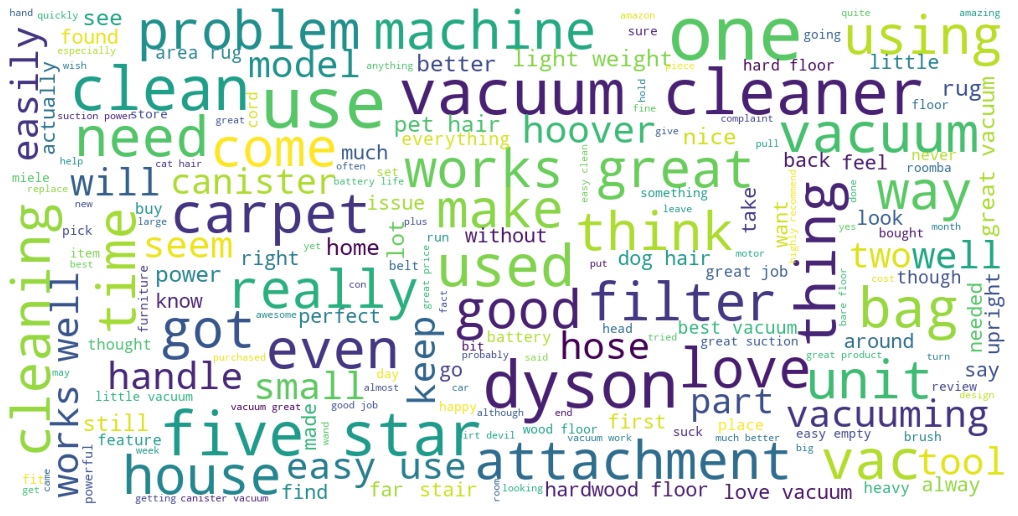

In [ ]:
visualize_wordcloud(text_positive)

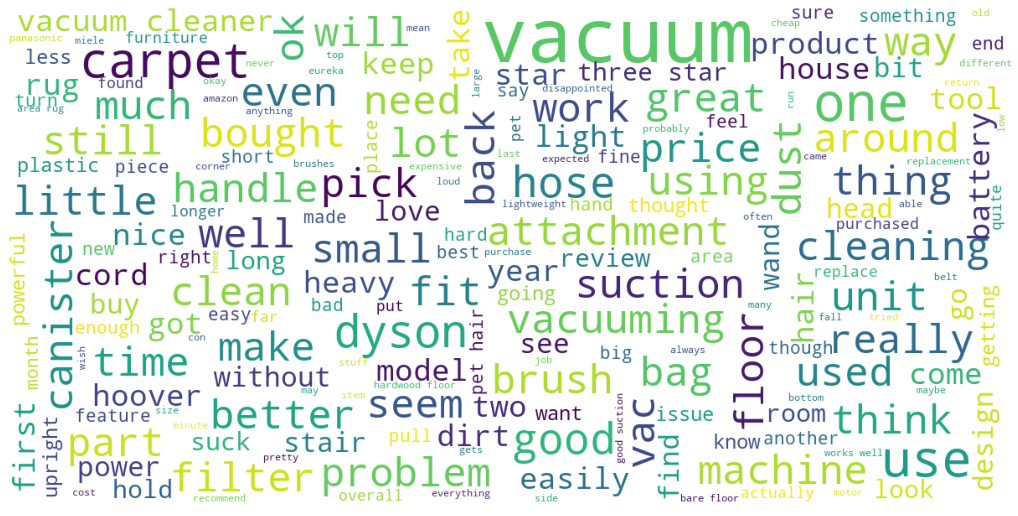

In [ ]:
visualize_wordcloud(text_neutral)

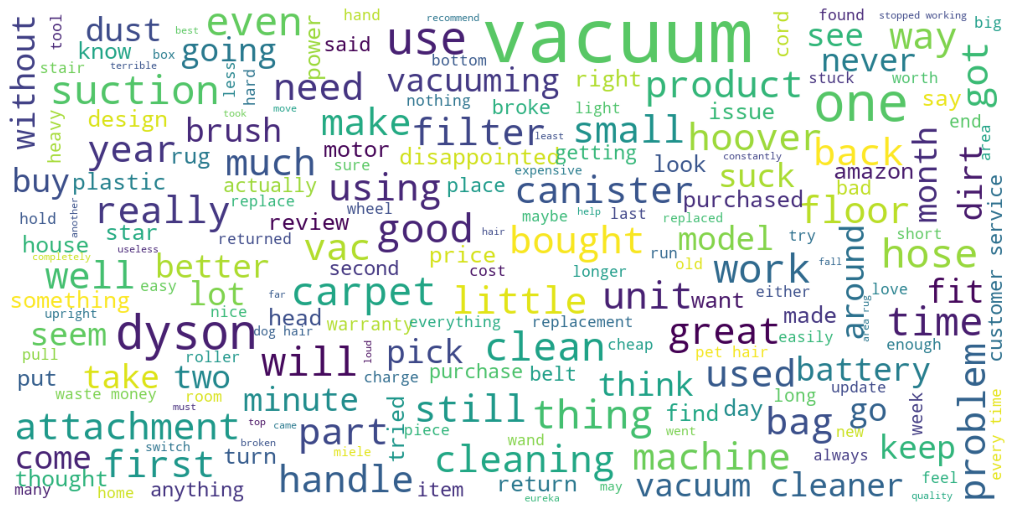

In [ ]:
visualize_wordcloud(text_negative)

# create Model

In [ ]:
reviews.head()

In [ ]:
reviews_w_tfidf = reviews_w_tfidf.sample(frac = 0.2, replace = False, random_state=42)

In [ ]:
reviews_w_tfidf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 6895 to 12212
Columns: 6382 entries, overall to zoom
dtypes: bool(1), float64(6368), int64(2), object(11)
memory usage: 1.5+ MB


In [ ]:
reviews_w_tfidf.head()

In [ ]:
ignored_columns = ["overall",	"verified",	"reviewTime",	"reviewerID",	"asin",	"reviewerName",	"unixReviewTime",	"category",	"description",	"title"	,"main_cat",	"review",	"label",	"class","brand"]
selected_features = [f for f in reviews_w_tfidf.columns if f not in ignored_columns]
y=reviews_w_tfidf["class"]
X=reviews_w_tfidf[selected_features]

In [ ]:
X.head()

,neg,neu,pos,compound,w_aaa,w_abilities,w_ability,w_able,w_about,w_above,w_abruptly,w_abs,w_absolute,w_absolutely,w_abuse,w_abused,w_ac,w_accent,w_accept,w_acceptable,w_accepted,w_access,w_accessible,w_accessing,w_accessories,w_accessory,w_accident,w_accidental,w_accidentally,w_accidently,w_accidents,w_accommodate,w_accomplish,w_accomplished,w_according,w_accordingly,w_accordion,w_account,w_accucharge,w_accumulate,...,w_wrote,w_xl,w_xmas,w_xv,w_ya,w_yank,w_yanking,w_yard,w_yay,w_yea,w_yeah,w_year,w_yearly,w_years,w_yellow,w_yep,w_yes,w_yesterday,w_yet,w_yikes,w_yo,w_you,w_youfive,w_youll,w_young,w_younger,w_youngest,w_your,w_yourself,w_youtube,w_yr,w_yrs,w_yuck,w_yucky,w_yup,w_zero,w_zing,w_zip,w_zipper,w_zoom
24359,0.139,0.592,0.270,0.4570,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6818,0.106,0.722,0.172,0.7599,0.0,0.0,0.0,0.076331,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.116552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7490,0.252,0.578,0.170,-0.9206,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.12792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12037,0.000,0.674,0.326,0.4404,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33909,0.101,0.682,0.216,0.7956,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
reviews_w_tfidf["class"].value_counts(normalize = True)

2    0.791764
0    0.130901
1    0.077335
Name: class, dtype: float64

In [ ]:
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({2: 2365, 0: 391, 1: 231})


In [ ]:
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [ ]:
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({2: 2365, 0: 2365, 1: 2365})


In [ ]:
#spit data set in train and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)


In [ ]:
from sklearn.naive_bayes import GaussianNB
# Create a Gaussian Classifier
model = GaussianNB()

In [ ]:
model.fit(X_train, y_train)

GaussianNB()

In [ ]:
predicted=model.predict(X_test)
print(predicted)
print(y_test)

[2 1 2 ... 0 0 2]
1024    2
5054    1
852     2
6867    1
3303    0
       ..
4367    0
2328    2
3016    0
3149    0
181     2
Name: class, Length: 1419, dtype: int64


# Evaluate the model

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,predicted))

0.8146582100070472


In [ ]:
class_names = ['2','1','0']

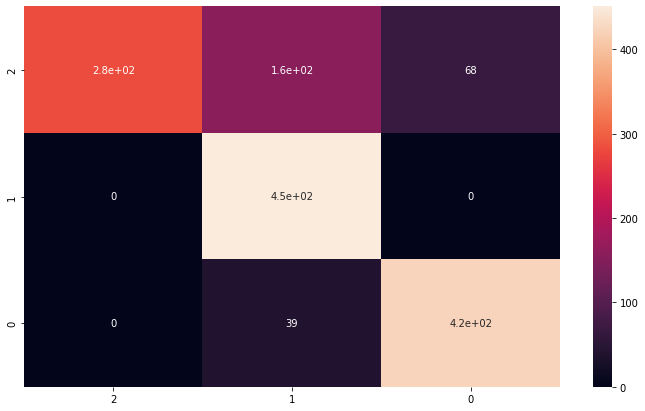

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predicted,labels=reviews["class"].unique())
#plot confusion matrix
confusion_matrix_df = pd.DataFrame(cf_matrix, index = [j for j in class_names],
                  columns = [j for j in class_names])
plt.figure(figsize = (12,7))
sns.heatmap(confusion_matrix_df , annot=True)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted, target_names=class_names))

              precision    recall  f1-score   support

           2       0.86      0.92      0.89       462
           1       0.70      1.00      0.82       451
           0       1.00      0.56      0.72       506

    accuracy                           0.81      1419
   macro avg       0.85      0.82      0.81      1419
weighted avg       0.86      0.81      0.81      1419

